# Language Modelling 101 

This notebook explores fundamental concepts in Natural Language Processing (NLP). These are the building blocks that allow machines to understand, process, and generate human language:

🔹 **Tokenization** breaks down raw text into smaller units like words, subwords, or characters.  
🔹 **Embeddings** map those tokens into dense vector spaces, enabling models to grasp semantic meaning and relationships between words.  
🔹 **Generation** train a model that predicts the next character in a sequence, forming the basis for simple text generation.

In [1]:
import torch
import numpy as np
import rich
import matplotlib.pyplot as plt

In [2]:
print("Downloading Shakespeare dataset...")

output_path = 'shakespeare.txt' 
url         = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'

!curl -L -o {output_path} {url}  

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1089k  100 1089k    0     0  4086k      0 --:--:-- --:--:-- --:--:-- 4094k


In [3]:
# 40,000 lines of Shakespeare from a variety of Shakespeare's plays
with open(output_path, 'r', encoding='utf-8') as f:
    text = f.read()

print(f'Length of dataset in characters: {len(text)}')
print('\nFirst 1000 characters:\n')
print(text[:1000])

Length of dataset in characters: 1115394

First 1000 characters:

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods k

## Character-Level Tokenization

In character-level tokenization, each unique character in the text becomes a token. This is the simplest form of tokenization! 

In [4]:
# Get all unique characters in the text
chars = sorted(list(set(text)))
vocab_size = len(chars)

print(f'Vocabulary size (unique characters): {vocab_size}')
print('\nAll characters:', ''.join(chars))

Vocabulary size (unique characters): 65

All characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz


In [5]:
# Create mappings from characters to integers and back
char_to_idx = {ch: i for i, ch in enumerate(chars)}
idx_to_char = {i: ch for i, ch in enumerate(chars)}

# Example: encode and decode some text
example_text = "Hello, World!"
encoded = [char_to_idx[ch] for ch in example_text]
decoded = ''.join([idx_to_char[idx] for idx in encoded])

rich.print(char_to_idx)
print(f'Original text: {example_text}')
print(f'Encoded: {encoded}')
print(f'Decoded: {decoded}')

{
    '\n': 0,
    ' ': 1,
    '!': 2,
    '$': 3,
    '&': 4,
    "'": 5,
    ',': 6,
    '-': 7,
    '.': 8,
    '3': 9,
    ':': 10,
    ';': 11,
    '?': 12,
    'A': 13,
    'B': 14,
    'C': 15,
    'D': 16,
    'E': 17,
    'F': 18,
    'G': 19,
    'H': 20,
    'I': 21,
    'J': 22,
    'K': 23,
    'L': 24,
    'M': 25,
    'N': 26,
    'O': 27,
    'P': 28,
    'Q': 29,
    'R': 30,
    'S': 31,
    'T': 32,
    'U': 33,
    'V': 34,
    'W': 35,
    'X': 36,
    'Y': 37,
    'Z': 38,
    'a': 39,
    'b': 40,
    'c': 41,
    'd': 42,
    'e': 43,
    'f': 44,
    'g': 45,
    'h': 46,
    'i': 47,
    'j': 48,
    'k': 49,
    'l': 50,
    'm': 51,
    'n': 52,
    'o': 53,
    'p': 54,
    'q': 55,
    'r': 56,
    's': 57,
    't': 58,
    'u': 59,
    'v': 60,
    'w': 61,
    'x': 62,
    'y': 63,
    'z': 64
}

Original text: Hello, World!
Encoded: [20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]
Decoded: Hello, World!


## Character Embeddings

Now we'll create character embeddings. Each character will be represented by a vector in a higher-dimensional space.

In [6]:
# Parameters for embeddings
embedding_dim = 2  # Dimension of the embedding space

# Create a random embedding table
embeddings = torch.nn.Embedding(vocab_size, embedding_dim)

# Example: get embeddings for a sequence of characters
example_sequence = torch.tensor(encoded)  # Using the encoded text from above
embedded_sequence = embeddings(example_sequence)

print(f'Shape of embedded sequence: {embedded_sequence.shape}')
print('\nEmbedding for first character:')
print(embedded_sequence[0].detach().numpy())

Shape of embedded sequence: torch.Size([13, 2])

Embedding for first character:
[-0.01936563  0.780907  ]


In [7]:
encoded

[20, 43, 50, 50, 53, 6, 1, 35, 53, 56, 50, 42, 2]

In [8]:
embeddings.weight.detach().numpy()

array([[-0.23932369,  0.46345592],
       [-0.6423792 , -0.7873385 ],
       [ 1.0079156 ,  1.328699  ],
       [-0.7498746 , -0.48523486],
       [-0.79671335,  0.9384049 ],
       [ 0.2674536 , -1.3672677 ],
       [-1.40885   ,  1.5491616 ],
       [ 0.4744425 ,  0.56318116],
       [-0.8355739 , -0.5237334 ],
       [-2.124052  , -0.36591074],
       [ 1.0824373 ,  0.41568   ],
       [ 0.8402554 ,  1.7635454 ],
       [ 1.2441891 , -0.5230278 ],
       [-0.08273728,  0.6018228 ],
       [-0.54837406, -1.4301887 ],
       [ 0.14188474, -0.814305  ],
       [-0.42370474,  0.879149  ],
       [-1.2385446 , -0.5392461 ],
       [ 0.7487016 , -0.30446163],
       [ 0.9765374 , -0.52477574],
       [-0.01936563,  0.780907  ],
       [-0.22606193,  2.662511  ],
       [ 1.4332491 ,  1.697618  ],
       [ 1.5200418 ,  0.90632784],
       [-0.13209035, -0.98281217],
       [-0.69555646,  0.7641147 ],
       [ 0.63517123, -0.6312587 ],
       [ 0.86430025, -0.06943191],
       [ 0.04671096,

## Visualizing Embeddings

We can visualize the learned embeddings by projecting them to 2D using PCA. As we defined by default only 2D, we can directly visualise them.

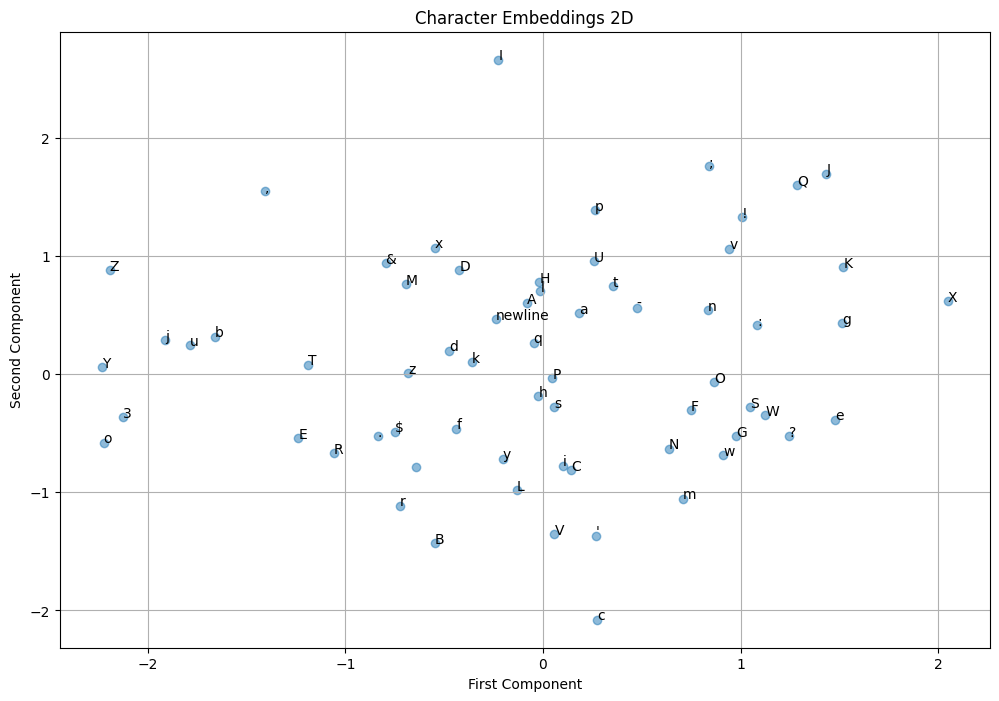

In [9]:
# Get the embedding weights
weights = embeddings.weight.detach().numpy()

# Plot
plt.figure(figsize=(12, 8))
plt.scatter(weights[:, 0], weights[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (weights[i, 0], weights[i, 1]))

plt.title('Character Embeddings 2D')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.grid(True)
plt.show()

# Train Embedding function - CBOW at Character Level

CBOW (Continuous Bag of Words) at a **character level** is a variant of the CBOW model used for learning vector representations of characters instead of words.

---

#### 🔹 How it Works:

1. **Context Window**: Select a window of characters around a target character (e.g., 2 characters before and 2 after).
   - For the word `"hello"`, if the target is `"l"` (the third character), the context might be `["h", "e", "l", "o"]`.

2. **Embedding**: Each context character is converted into a vector using an embedding layer.

3. **Averaging**: The vectors of the context characters are averaged to form a single context vector (note no notion of relative position, hence **bag** of characters).

4. **Prediction**: A softmax layer predicts the target character based on the context vector.

---  


#### 🔹 Training process:

1. **Simple NN**: We will define a simple NN architecture: Embeddings layer + output layer. 

2. **Loss function**: By considering CrossEntropy, we will calculate the loss function with the predicted characters vs the true center characters for each context.

In [10]:
# Example of how we create training pairs
def show_data_preparation_example():
    # Take a small sample of text
    sample_text = "Hello, World!"
    print(f"Sample text: {sample_text}")
    
    # Convert to indices
    indices = [char_to_idx[ch] for ch in sample_text]
    context_size = 2
    
    print("\nCreating context windows (context_size=2):")
    print("Center char | Context chars (2 before, 2 after)")
    print("-" * 45)
    
    # Show some examples
    for i in range(context_size, len(indices) - context_size):
        center_char = sample_text[i]
        context_chars = (
            sample_text[i-context_size:i] + '*' +
            sample_text[i+1:i+context_size+1]
        )
        
        print(f"    {center_char}     | {context_chars}")
        
    print("\nThese will be converted to tensor indices for training.")
    
# Run the example
show_data_preparation_example()

Sample text: Hello, World!

Creating context windows (context_size=2):
Center char | Context chars (2 before, 2 after)
---------------------------------------------
    l     | He*lo
    l     | el*o,
    o     | ll*, 
    ,     | lo* W
          | o,*Wo
    W     | , *or
    o     |  W*rl
    r     | Wo*ld
    l     | or*d!

These will be converted to tensor indices for training.


In [11]:
# Convert text to indices tensor
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

print(f"Shape of data tensor: {data.shape}")
print(f"First 20 characters as indices: {data[:20]}")
print(f"As characters: {''.join([idx_to_char[idx.item()] for idx in data[:20]])}")

Shape of data tensor: torch.Size([1115394])
First 20 characters as indices: tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56])
As characters: First Citizen:
Befor


In [12]:
# Model parameters
embedding_dim = 2
context_size  = 2
batch_size    = 1024
learning_rate = 0.001

In [13]:
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np

class SkipgramDataset(Dataset):
    def __init__(self, data, context_size):
        self.data = data
        self.context_size = context_size
        self.pairs = []
        
        # Create training pairs
        for i in range(context_size, len(data) - context_size):
            center = data[i]
            context = torch.cat([
                data[i-context_size:i],
                data[i+1:i+context_size+1]
            ])
            self.pairs.append((center, context))
    
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        return center, context

# Create dataset and dataloader
dataset = SkipgramDataset(data, context_size)

train_size = int(0.8*len(dataset))
val_size   = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_dataloader           = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_dataloader      = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

rich.print(f'Number of training examples: {len(train_dataset):,}')
rich.print(f'Number of validation examples: {len(val_dataset):,}')
rich.print(f'Number of batches: {len(train_dataloader):,}')

Number of training examples: 892,312

Number of validation examples: 223,078

Number of batches: 872

In [14]:
datapoint = 0
center    = idx_to_char[dataset[datapoint][0].item()]
context   = ''
for val in dataset[datapoint][1]:
    context += idx_to_char[val.item()]

print( f'Center: {center} | Context: {context[:2]}*{context[2:]}' )

Center: r | Context: Fi*st


# 1. Simplest approach

In [15]:
import torch
import torch.nn as nn

class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        # Embedding layer for context characters
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        # Output layer to predict center character
        self.output = nn.Linear(embedding_dim, vocab_size)
        
    def forward(self, center_chars, context_chars):
        # Get embeddings for context characters
        context_embeds = self.embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Average context embeddings
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embedding_dim]
        
        # Predict center character
        logits = self.output(context_embeds)  # [batch_size, vocab_size]
        
        return logits

In [16]:
# Initialize model, optimizer, and loss function
model = CharacterEmbedding(vocab_size, embedding_dim)

# Use AdamW optimizer with weight decay for better regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

print(model)

CharacterEmbedding(
  (embeddings): Embedding(65, 2)
  (output): Linear(in_features=2, out_features=65, bias=True)
)


In [17]:
def train_embedding_epoch( model, train_dataloader, val_dataloader, optimizer, criterion):
    
    # -- Training loop --
    model.train()
    train_loss = 0
    with tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{n_epochs}') as pbar:
        for center, context in pbar:
            # Forward pass
            logits = model(center, context)
            
            # Compute loss
            loss = criterion(logits, center)
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # Update metrics
            train_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
    train_loss = train_loss / len(train_dataloader)

    # --- Validation loop ---
    model.eval()
    val_loss   = 0
    with torch.no_grad():
        for center, context in val_dataloader:
            logits    = model(center, context)
            loss      = criterion(logits, center)
            val_loss += loss.item()
    validation_loss = val_loss / len(val_dataloader)

    train_loss = 0
    with torch.no_grad():
        for center, context in train_dataloader:
            logits    = model(center, context)
            loss      = criterion(logits, center)
            train_loss += loss.item()
    train_loss      = train_loss / len(train_dataloader)

    return train_loss, validation_loss

def plot_losses( losses, val_losses ):
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Train')
    plt.plot(val_losses, label='Val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

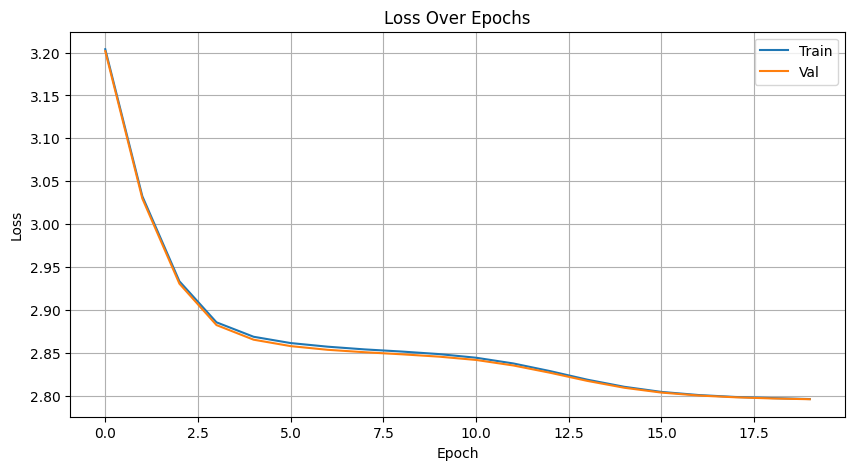

In [18]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Training loop
n_epochs = 20
losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss, val_loss = train_embedding_epoch( model, train_dataloader, validation_dataloader, optimizer, criterion )

    losses.append( train_loss )
    val_losses.append( val_loss )
    
    # Plot the loss
    plot_losses( losses, val_losses )

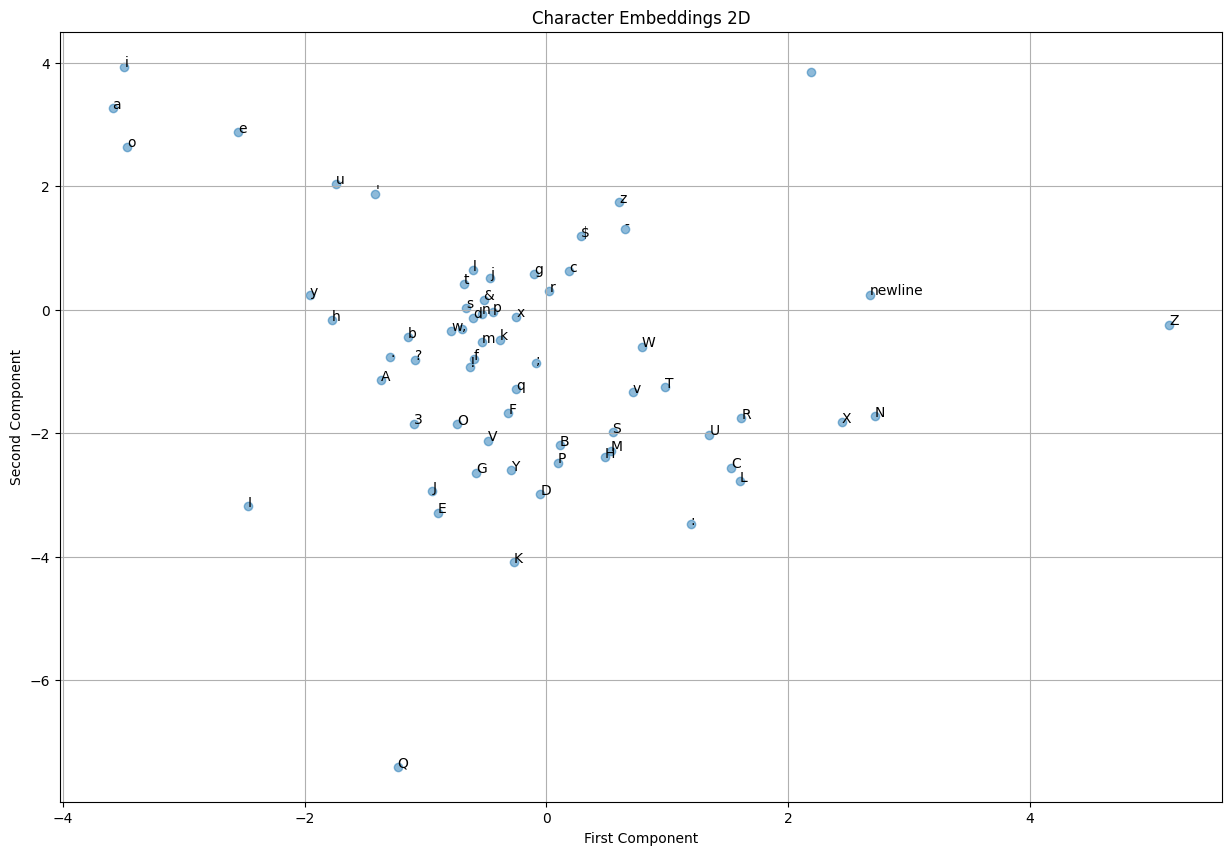

In [19]:
# Get the trained embeddings (we use the main embeddings, not the context ones)
trained_embeddings = model.embeddings.weight.detach().numpy()

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(trained_embeddings[:, 0], trained_embeddings[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (trained_embeddings[i, 0], trained_embeddings[i, 1]))

plt.title('Character Embeddings 2D')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.grid(True)
plt.show()

# 2. Add a hidden layer 

In [20]:
class CharacterEmbedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim=64):
        super().__init__()
        
        # Embedding layer
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)

        # Add batch normalization for better training stability
        self.batch_norm = nn.BatchNorm1d(embedding_dim)
        
        # Hidden layers
        self.hidden = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)  # Add dropout for regularization
        )
        
        # Output layer to predict center character
        self.output = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, center_chars, context_chars):
        # Get embeddings for context characters
        context_embeds = self.embeddings(context_chars)  # [batch_size, context_size*2, embedding_dim]
        
        # Average context embeddings
        context_embeds = context_embeds.mean(dim=1)  # [batch_size, embedding_dim]
        context_embeds = self.batch_norm(context_embeds)
        
        # Pass through hidden layers
        hidden = self.hidden(context_embeds)  # [batch_size, hidden_dim]
        
        # Predict center character
        logits = self.output(hidden)  # [batch_size, vocab_size]
        
        return logits

In [21]:
# Initialize model, optimizer, and loss function
model = CharacterEmbedding(vocab_size, embedding_dim)

# Use AdamW optimizer with weight decay for better regularization
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Keep using CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

print(model)

CharacterEmbedding(
  (embeddings): Embedding(65, 2)
  (batch_norm): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (output): Linear(in_features=64, out_features=65, bias=True)
)


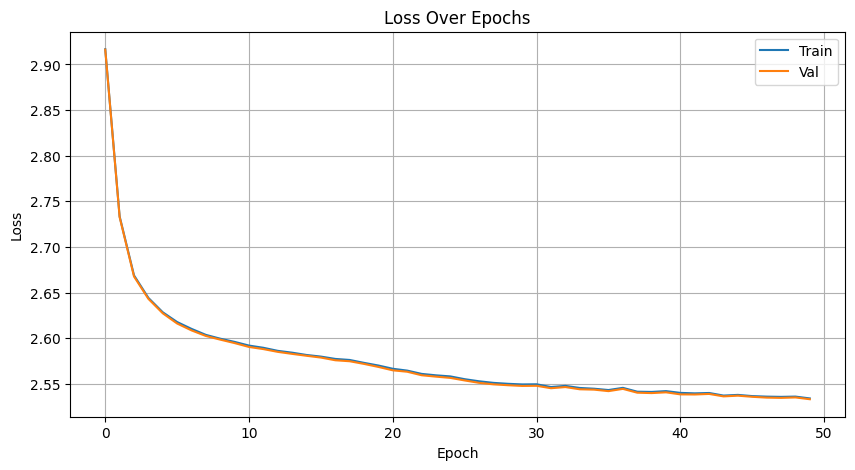

In [22]:
# Training loop
n_epochs = 50
losses, val_losses = [], []

for epoch in range(n_epochs):
    train_loss, val_loss = train_embedding_epoch( model, train_dataloader, validation_dataloader, optimizer, criterion )

    losses.append( train_loss )
    val_losses.append( val_loss )
    
    # Plot the losses
    plot_losses( losses, val_losses )

In [23]:
# Save the trained model
torch.save(model.state_dict(), "embeddings_model.pth")

In [24]:
# Load pre-trained model 
embeddings_model_path = 'embeddings_model.pth'
embeddings_model_url  = 'https://raw.githubusercontent.com/marc-olm/genai101/main/notebooks/embeddings_model.pth'

!curl -L -o  {embeddings_model_path} {embeddings_model_url}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22134  100 22134    0     0  69397      0 --:--:-- --:--:-- --:--:-- 69603


In [25]:
# Load the state dict
model.load_state_dict(torch.load(embeddings_model_path))

<All keys matched successfully>

# Viz new embeddings

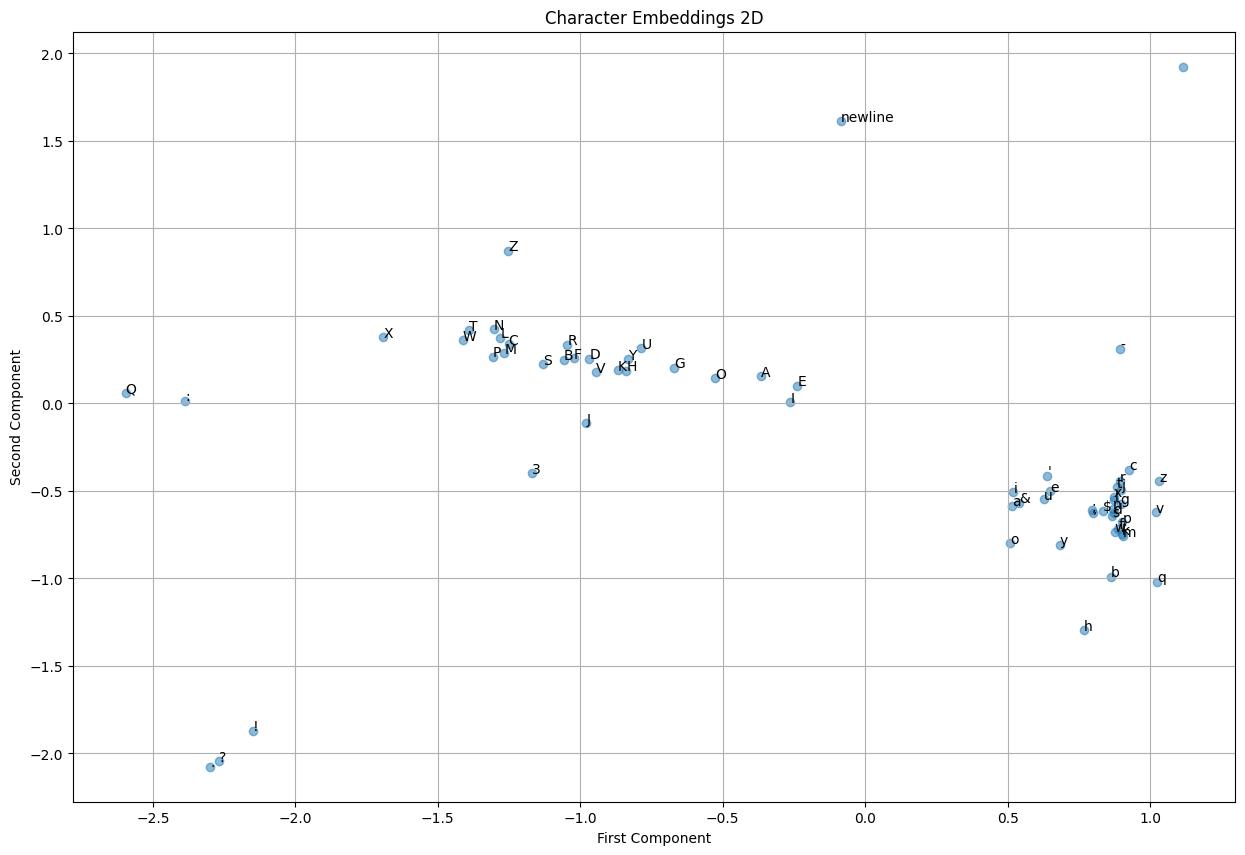

In [26]:
# Get the trained embeddings (we use the main embeddings, not the context ones)
trained_embeddings = model.embeddings.weight.detach().numpy()

# Plot
plt.figure(figsize=(15, 10))
plt.scatter(trained_embeddings[:, 0], trained_embeddings[:, 1], alpha=0.5)

# Add character labels
for i, char in enumerate(chars):
    if char == '\n': char = 'newline'  # Make newline visible
    plt.annotate(char, (trained_embeddings[i, 0], trained_embeddings[i, 1]))

plt.title('Character Embeddings 2D')
plt.xlabel('First Component')
plt.ylabel('Second Component')
plt.grid(True)
plt.show()

# Now, train a model to produce new characters! 

### LSTM-Based Character-Level Language Model

This model (`CharacterLM`) is a **character-level language model**. It learns to predict the **next character** in a sequence using an LSTM (Long Short-Term Memory) network, using the next character as the target. 

---

#### 🔹 How it Works:

1. **Input**: A sequence of characters, represented as integer indices. Next character predictor, based on the previous context. 
   
2. **Embedding Layer**: Converts each character index into a dense vector of size `embedding_dim`.

3. **LSTM Layer**: Processes the sequence of embeddings, capturing contextual information and dependencies between characters.

4. **Fully Connected Layer**: Output layer, projects the LSTM outputs to the vocabulary size, producing a distribution over possible next characters at each position.

5. **Loss Function**: Cross-entropy is used to compare predicted character probabilities against the actual next character.

In [27]:
# Convert entire text to indices
data = torch.tensor([char_to_idx[ch] for ch in text], dtype=torch.long)

# Create sequences of context_length characters
context_length = 4
x = torch.stack([data[i:i+context_length] for i in range(len(data)-context_length)])
y = data[context_length:]

print(f'Shape of input sequences: {x.shape}')
print(f'Shape of target values: {y.shape}')

# Show an example
idx = 0  # First sequence
context = ''.join([idx_to_char[int(i)] for i in x[idx]])
next_char = idx_to_char[int(y[idx])]
print(f'\nExample:')
print(f'Context: "{context}"')
print(f'Next character: "{next_char}"')

Shape of input sequences: torch.Size([1115390, 4])
Shape of target values: torch.Size([1115390])

Example:
Context: "Firs"
Next character: "t"


In [28]:
import torch.nn as nn
import torch.nn.functional as F

class CharacterLM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        embedded = self.embeddings(x)  # (batch_size, sequence_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # (batch_size, sequence_length, hidden_dim)
        logits = self.fc(lstm_out)  # (batch_size, sequence_length, vocab_size)
        return logits

# Model parameters
embedding_dim  = 16
hidden_dim     = 32
context_length = 16
batch_size     = 128

# Initialize model
model = CharacterLM(vocab_size, embedding_dim, hidden_dim)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

print(f'Model parameters: {sum(p.numel() for p in model.parameters()):,}')

Model parameters: 9,585


In [29]:
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, data, context_length):
        self.data = data
        self.context_length = context_length
    
    def __len__(self):
        return len(self.data) - self.context_length - 1
    
    def __getitem__(self, idx):
        # Get input sequence and target
        x = self.data[idx:idx + self.context_length]
        y = self.data[idx + 1:idx + self.context_length + 1]
        return x, y

# Create dataset and dataloader
dataset = TextDataset(data, context_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

print(f'Number of training examples: {len(dataset):,}')
print(f'Number of batches: {len(dataloader):,}')

Number of training examples: 1,115,377
Number of batches: 8,714


In [30]:
dataset[1]

(tensor([47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43]),
 tensor([56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44]))

In [31]:
def train_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    
    for x, y in tqdm(dataloader, desc='Training'):
        # Forward pass
        logits = model(x)
        loss = criterion(logits.view(-1, vocab_size), y.view(-1))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    return total_loss / len(dataloader)

Epoch 20/20, Loss: 1.7853


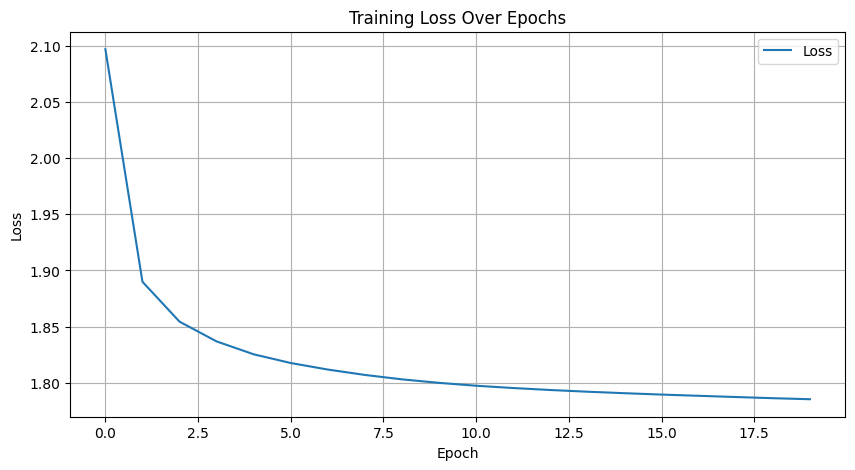

In [32]:
# Training parameters
n_epochs = 20

# Train the model
losses = []
for epoch in range(n_epochs):
    loss = train_epoch(model, dataloader, optimizer, criterion)
    losses.append(loss)

    # Plot the loss
    clear_output(wait=True)
    print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss:.4f}')

    plt.figure(figsize=(10, 5))
    plt.plot(losses, label='Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

In [33]:
# Save the trained model
torch.save(model.state_dict(), "character_generator_model.pth")

In [34]:
# Load pre-trained model 
character_generator_model_path = 'character_generator_model.pth'
character_generator_model_url  = 'https://raw.githubusercontent.com/marc-olm/genai101/main/notebooks/character_generator_model.pth'

!curl -L -o {character_generator_model_path} {character_generator_model_url}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41482  100 41482    0     0   129k      0 --:--:-- --:--:-- --:--:--  129k


In [35]:
# Load the state dict
model.load_state_dict(torch.load(character_generator_model_path))

<All keys matched successfully>

In [36]:
@torch.no_grad()
def generate_text(model, start_text, max_length=200, temperature=1.0):
    model.eval()
    
    # Convert start text to indices
    context = torch.tensor([char_to_idx[ch] for ch in start_text])
    generated_text = start_text
    
    for _ in range(max_length):
        # Get model predictions
        x = context[-context_length:].unsqueeze(0)  # Add batch dimension
        logits = model(x)
        probs = F.softmax(logits[0, -1] / temperature, dim=0)
        
        # Sample next character
        next_idx = torch.multinomial(probs, 1).item()
        next_char = idx_to_char[next_idx]
        
        # Update context and generated text
        generated_text += next_char
        context = torch.cat([context, torch.tensor([next_idx])])
    
    return generated_text

In [37]:
# Generate some text
prompt = "To be, or not to be"

rich.print(f'\nPrompt: "{prompt}"')
rich.print('\n\nCompletions:')
rich.print(generate_text(model, prompt, max_length=200, temperature=0.3))

Prompt: "To be, or not to be"

Completions:

To be, or not to be the some the prest a to the grace the best me the son the have a man it and shall so the have 
have heaven the see the striter hearting the come to your have the king in the do the some the some the w

In [38]:
# Generate some text
prompt = "Oh Romeo, Romeo, "

rich.print(f'\nPrompt: "{prompt}"')
rich.print('\n\nCompletions:')
rich.print(generate_text(model, prompt, max_length=200, temperature=0.5))

Prompt: "Oh Romeo, Romeo, "

Completions:

Oh Romeo, Romeo, and he struck for the stain,
How have all for the good the will for my best me the part of the to protions, and are not so to his compervering 
for a proved upon a be all a pear the not shall the say f

In [40]:
# Create a Shakesperian name! 
# Since the learned representation contains uppercase for character names 
prompt = "MARC"

rich.print(f'\nPrompt: "{prompt}"')

completion = generate_text(model, prompt, max_length=10, temperature=0.5)
# rich.print(completion)
rich.print( f'Shakespearean name: "{completion.split(":")[0]}"' )

Prompt: "MARC"

Shakespearean name: "MARCIUS"